# Theory

## BM Quadratic Variation

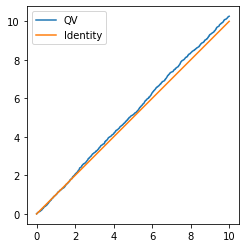

In [1]:
import numpy as np
from pandas import DataFrame

T = 10
n = 2500
dt = T/n

ax = DataFrame({'QV': (np.random.normal(0, np.sqrt(dt), n)**2).cumsum(), 
                'Identity': np.arange(dt, T+dt, dt)
               }, 
               index=np.arange(dt, T+dt, dt)).plot()
ax.set_aspect(1)


## SV Models

All models below are in the risk-neutral world and there can be a price-volatility correlation, meaning $dZ_tdW_t = \rho dt$.

![](../fig/sv.png)


From wikipedia: 
[SV Models](https://en.wikipedia.org/wiki/Stochastic_volatility), 
[CEV](https://en.wikipedia.org/wiki/Constant_elasticity_of_variance_model), 
[LV](https://en.wikipedia.org/wiki/Local_volatility), 
[SABR](https://en.wikipedia.org/wiki/SABR_volatility_model)


[GARCH(1, 1) limiting case derivation](https://math.berkeley.edu/~btw/thesis4.pdf)


MD 表 + 連結 + 數學符號 publish 之後會爛掉。這裡放的是圖。原本的 code 在下面被 comment out。圖其實可以不用存起來，直接 snipping tool 剪下之後在 cell 裡貼上就可以了

<!--
|Model| Dynamics | Speed Log Return QV Increase | Note
|--|--|--|--|
|[CEV](https://en.wikipedia.org/wiki/Constant_elasticity_of_variance_model)|$$dS_t = rS_t dt + \sigma S_t^{\beta} dW_t$$ | $$\sigma^2S_t^{2(\beta -1)}$$ | $$\beta< 1: \text{leverage effect; }\beta> 1: \text{inverse leverage effect}$$ |
|[LV](https://en.wikipedia.org/wiki/Local_volatility)| $$dS_t = rS_t dt + \sigma(t, S_t) S_t dW_t$$ | $$\sigma^2(t, S_t)$$ ||
|Heston|$$
\begin{cases}
dS_t = rS_tdt + \sqrt{V_t}S_t dW_t\\
dV_t = \theta(\kappa - V_t)dt + \sigma\sqrt{V_t} dZ_t
\end{cases}
$$| $$V_t$$ | $$V_t \text{ accumulates QV at the speed } \sigma^2 V_t$$ |
|[SABR](https://en.wikipedia.org/wiki/SABR_volatility_model)|$$
\begin{cases}
dF_t = \sigma_tF_t^{\beta} dW_t\\
d\sigma_t = \alpha\sigma_t dZ_t
\end{cases}
$$| $$\sigma_t^2F_t^{2(\beta -1)}$$ | $$\sigma_t \text{ accumulates QV at the speed } \alpha^2 \sigma_t^2$$ |
| GARCH(1, 1)|$$
dV_t = \theta(\kappa-V_t)dt + \sigma V_t dW_t
$$| $$?$$ | $$V_t \text{ accumulates QV at the speed } \sigma^2 V_t^2$$ Derivation of limiting case see [here](https://math.berkeley.edu/~btw/thesis4.pdf)|
-->

## Empirically...

* The log return of S&P 500 doesn't accumulate QV at a constant rate $\sigma^2$ per unit time as it's assumed in the Black-Scholes model
* The Heston model assumes that the log return accumulates QV at the rate of the volatility $V_t$, and the volatility accumulates QV at the rate of $\sigma^2 V_t$. So the speed the log return accumulates QV is a constant times the speed the volatility accumulates QV. 

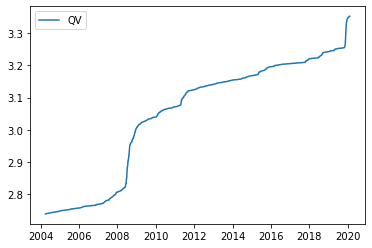

In [3]:
from pandas import DataFrame
import pandas as pd
import numpy as np

# data from 1928/1/1 - 2020/6/1

df = pd.read_csv('../data/^GSPC.csv').set_index('Date')
df = np.log(df[['Adj Close']].pct_change()[1:] + 1)

log_return = df.values

n = len(log_return)
dt = 1/252
ax = DataFrame({'QV': (log_return**2).cumsum()}, index=np.arange(dt+1928, (n+1)*dt+1928, dt)).tail(4000).plot()
# ax.set_aspect(1)



## [Penalty Method for American Put Pricing](https://cs.uwaterloo.ca/~paforsyt/con7.pdf)

$$
V_{\tau} = \frac{\sigma^2S^2}{2}V_{SS} + rSV_S - rV + \rho\max(V^{*}-V, 0), 
$$
where $V^* = (K-S)^+$ is the payoff function, and $\rho$ is a large number. 

* Above the early exercise boundary, the penalty term disappears and the PDE reduces to the Black-Scholes PDE
* Below the boundary, the penalty term dominates and PDE is approximately $V_{\tau} = \rho(V^{*}-V)$ whose solution is $V = V^{*}$


## Method of Moments for Merton's Jump Diffusion Model 

Under Merton's Jump diffusion model, the stock price is assumed to follow 
$$
S_t = S_0 e^{\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t + \sum_{i=1}^{N_t}X_i}, 
$$
where $W_t$ is the standard Brownian motion, $N_t$ is the Poisson process with parameter $\lambda$, and $X_i$'s are iid normal random variables with mean $\alpha$ and variance $\beta^2$. 
Note that this model has 5 parameters to estimate: $\mu, \sigma, \lambda, \alpha$ and $\beta$. 
Given any integer $n$ and a fixed time horizon $T$, define $\Delta t = T/n$ and $t_i = i\Delta t$. 
Under Merton's assumption, the log return $R_i = \log(S_{t_{i+1}}/S_{t_i})$ can be shown to be iid with MGF
$$
\phi_R(u) = E\left[e^{uR_i}\right] = \exp\left(\Delta t\left[u\left(\mu - \frac{\sigma^2}{2}\right) + \frac{\sigma^2 u^2}{2} + \lambda\left(e^{\alpha u + \frac{\beta^2 u^2}{2}} - 1\right)\right]\right), 
$$
the $j$th derivative of which at 0 gives the $j$th raw moment $m_j$ of the log return. Below is the first 5: 
\begin{align*}
m_1 &= \Delta t  \left(\alpha  \lambda +\mu -\frac{\sigma^2}{2}\right), \\
m_2 &= \Delta t  \left(\alpha^2 \lambda +\Delta t  \left(\alpha  \lambda +\mu -\frac{\sigma^2}{2}\right)^2+\beta^2 \lambda +\sigma^2\right), \\
m_3 &= \alpha^3 \lambda  \Delta t +\frac{3}{2} \Delta t^2 \left(\alpha^2 \lambda +\beta^2 \lambda +\sigma^2\right) \left(2 \alpha  \lambda +2 \mu -\sigma^2\right)+3 \alpha  \beta^2 \lambda  \Delta t +\Delta t^3 \left(\alpha  \lambda +\mu -\frac{\sigma^2}{2}\right)^3, \\
m_4 &= \frac{1}{2} \Delta t  \left(2 \alpha^4 \lambda +3 \Delta t^2 \left(\alpha^2 \lambda +\beta^2\lambda +\sigma^2\right) \left(-2 \alpha  \lambda -2 \mu +\sigma^2\right)^2+4 \alpha \lambda  \Delta t  \left(\alpha^2+3 \beta^2\right) \left(2 \alpha  \lambda +2 \mu -\sigma^2\right)+6 \Delta t  \left(\alpha^2 \lambda +\beta^2 \lambda +\sigma^2\right)^2+12 \alpha^2 \beta^2 \lambda +2 \Delta t^3 \left(\alpha  \lambda +\mu -\frac{\sigma^2}{2}\right)^4+6\beta^4 \lambda \right), \\
m_5 &= \frac{1}{4} \Delta t  \left(4 \alpha^5 \lambda +40 \alpha^3 \beta^2 \lambda +5 \Delta t^3\left(\alpha^2 \lambda +\beta^2 \lambda +\sigma^2\right) \left(2 \alpha  \lambda +2 \mu-\sigma^2\right)^3+10 \alpha  \lambda  \Delta t^2 \left(\alpha^2+3 \beta^2\right) \left(-2\alpha  \lambda -2 \mu +\sigma^2\right)^2+30 \Delta t^2 \left(\alpha^2 \lambda +\beta^2\lambda +\sigma^2\right)^2 \left(2 \alpha  \lambda +2 \mu -\sigma^2\right)+40 \alpha \lambda  \Delta t  \left(\alpha^2+3 \beta^2\right) \left(\alpha^2 \lambda +\beta^2 \lambda+\sigma^2\right)+10 \lambda  \Delta t  \left(\alpha^4+6 \alpha^2 \beta^2+3 \beta^4\right)\left(2 \alpha  \lambda +2 \mu -\sigma^2\right)+60 \alpha  \beta^4 \lambda +4 \Delta t^4\left(\alpha  \lambda +\mu -\frac{\sigma^2}{2}\right)^5\right). 
\end{align*}
Matching these formulas to the sample moments of the empirical log return, we get a high order polynomial equation (for example the last term of $m_5$ is of degree 10), and the solution could easily be complex numbers. 
I did an experiment years ago fitting this model to the daily log return of S&P 500. The result is lost now but it does get complex numbers everywhere. 



\begin{align*}
m_1 &= \Delta t\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right),\\
m_2 &= \Delta t\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2+\Delta t\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^2\right),\\
m_3 &= \Delta t\left(\alpha^3\lambda+3\alpha\beta^2\lambda+3\Delta t\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)+\Delta t^2\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^3\right),\\
m_4 &= \Delta t\left(\alpha^4\lambda+6\alpha^2\beta^2\lambda+3\beta^4\lambda+6\Delta t^2\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^2+4\alpha\lambda\Delta t\left(\alpha^2+3\beta^2\right)\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)+3\Delta t\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)^2+\Delta t^3\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^4\right),\\
m_5 &= \Delta t\left(\alpha^5\lambda+10\alpha^3\beta^2\lambda+15\alpha\beta^4\lambda+10\Delta t^3\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^3+\frac{5}{2}\alpha\lambda\Delta t^2\left(\alpha^2+3\beta^2\right)\left(-2\alpha\lambda-2\mu+\sigma^2\right)^2+15\Delta t^2\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)^2\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)+10\alpha\lambda\Delta t\left(\alpha^2+3\beta^2\right)\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)+5\lambda\Delta t\left(\alpha^4+6\alpha^2\beta^2+3\beta^4\right)\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)+\Delta t^4\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^5\right),
\end{align*}

### Closed Form Estimators

It might not be obvious but the MOM estimators in this situation can actually be found in closed form. Below are the keys steps to derive the estimators. First denote by $\hat m_j$ the sample moments from empirical data. Our goal is to solve the following system of equations for the five model parameters $\mu, \sigma, \lambda, \alpha$ and $\beta$: 
\begin{align*}
\hat m_1 &= \Delta t\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right),\\
\hat m_2 &= \Delta t\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2+\Delta t\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^2\right),\\
\hat m_3 &= \Delta t\left(\alpha^3\lambda+3\alpha\beta^2\lambda+3\Delta t\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)+\Delta t^2\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^3\right),\\
\hat m_4 &= \Delta t\left(\alpha^4\lambda+6\alpha^2\beta^2\lambda+3\beta^4\lambda+6\Delta t^2\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^2+4\alpha\lambda\Delta t\left(\alpha^2+3\beta^2\right)\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)+3\Delta t\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)^2+\Delta t^3\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^4\right),\\
\hat m_5 &= \Delta t\left(\alpha^5\lambda+10\alpha^3\beta^2\lambda+15\alpha\beta^4\lambda+10\Delta t^3\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^3+\frac{5}{2}\alpha\lambda\Delta t^2\left(\alpha^2+3\beta^2\right)\left(-2\alpha\lambda-2\mu+\sigma^2\right)^2+15\Delta t^2\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)^2\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)+10\alpha\lambda\Delta t\left(\alpha^2+3\beta^2\right)\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)+5\lambda\Delta t\left(\alpha^4+6\alpha^2\beta^2+3\beta^4\right)\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)+\Delta t^4\left(\alpha\lambda+\mu-\frac{\sigma^2}{2}\right)^5\right),
\end{align*}
where $\Delta t$ and $\hat m_j$ are known constants. 

First note that there are some common terms on the right hand side of the equations. By applying the substitutions
\begin{align*}
A &= \alpha \lambda +\mu -\frac{\sigma^2}{2}, \\
B &= \alpha^2 \lambda +\beta^2 \lambda +\sigma^2, \\
C &= \alpha^3\lambda+3\alpha\beta^2\lambda, \\
D &= \alpha^4\lambda+6\alpha^2\beta^2\lambda+3\beta^4\lambda, \\
E &= \alpha^5\lambda+10\alpha^3\beta^2\lambda+15\alpha\beta^4\lambda, 
\end{align*}
the system can be rewritten in a much cleaner form: 
\begin{align*}
\hat m_1 &= \Delta tA,\\
\hat m_2 &= \Delta t\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2+\Delta tA^2\right),\\
\hat m_3 &= \Delta t\left(\alpha^3\lambda+3\alpha\beta^2\lambda+3\Delta t\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)A+\Delta t^2A^3\right),\\
\hat m_4 &= \Delta t\left(\alpha^4\lambda+6\alpha^2\beta^2\lambda+3\beta^4\lambda+6\Delta t^2\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)A^2+4\alpha\lambda\Delta t\left(\alpha^2+3\beta^2\right)A+3\Delta t\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)^2+\Delta t^3A^4\right),\\
\hat m_5 &= \Delta t\left(\alpha^5\lambda+10\alpha^3\beta^2\lambda+15\alpha\beta^4\lambda+10\Delta t^3\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)A^3+10\alpha\lambda\Delta t^2\left(\alpha^2+3\beta^2\right)A^2+15\Delta t^2\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)^2A+10\alpha\lambda\Delta t\left(\alpha^2+3\beta^2\right)\left(\alpha^2\lambda+\beta^2\lambda+\sigma^2\right)+5\lambda\Delta t\left(\alpha^4+6\alpha^2\beta^2+3\beta^4\right)A+\Delta t^4A^5\right),
\end{align*}


\begin{align*}
\hat m_1 &= \Delta tA,\\
\hat m_2 &= \Delta t\left(B + \Delta tA^2\right),\\
\hat m_3 &= \Delta t\left(C + 3\Delta tBA + \Delta t^2A^3\right),\\
\hat m_4 &= \Delta t\left(D + 6\Delta t^2BA^2 + 4\Delta tCA + 3\Delta tB^2 + \Delta t^3A^4\right),\\
\hat m_5 &= \Delta t\left(E + 10\Delta t^3BA^3 + 10\Delta t^2CA^2 + 15\Delta t^2B^2A + 10\Delta tCB + 5\Delta tDA + \Delta t^4A^5\right),
\end{align*}
